In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.cluster import KMeans
from itertools import product
import torch
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from utils import tMCL
from utils import kl_eigenfunctions, generate_quantization_points, reconstruct_quantized_trajectories,generate_brownian_motion,plot_brownian_trajectories,plot_brownian_bridge_samples,generate_brownian_bridge_samples

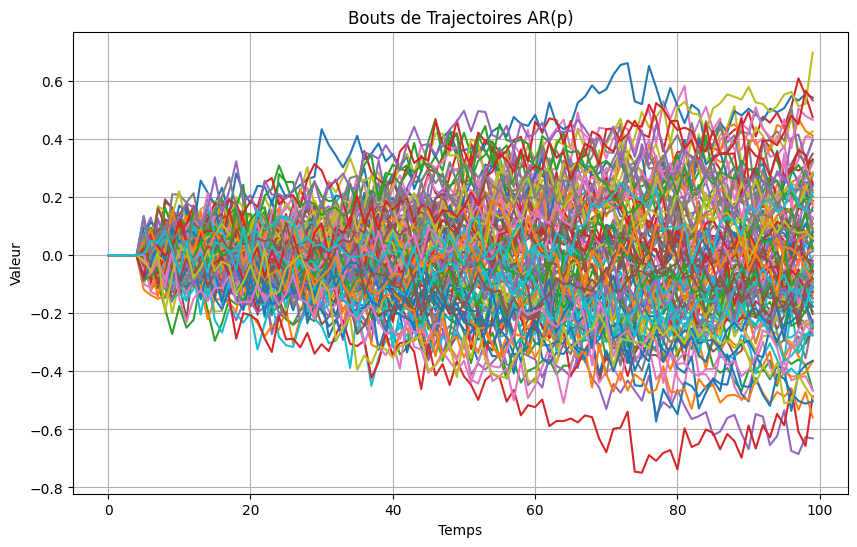

In [2]:
def generate_ARp_samples(batch_size, nb_discretization_points, interval_length, coefficients, sigma=0.05, init_values=None):
    """
    Génère des trajectoires complètes d'un processus AR(p) et extrait des sous-trajets.

    :param batch_size: Nombre de sous-trajets à générer
    :param nb_discretization_points: Nombre total de points de discrétisation
    :param interval_length: Nombre de points dans chaque sous-trajet (bouts)
    :param coefficients: Liste des coefficients [alpha1, alpha2, ..., alpha_p] pour le processus AR(p)
    :param sigma: Écart-type du bruit blanc
    :param seed: Graine pour la reproductibilité
    :param init_values: Valeurs initiales optionnelles (liste de longueur p) ou None pour aléatoire
    :param fixed_start: Si True, les sous-trajectoires commencent toutes à un même instant initial
    :return:
        - Tenseur de dimension (batch_size, interval_length, 1) contenant les sous-trajets
    """
    p = len(coefficients)
    if interval_length > nb_discretization_points:
        raise ValueError("`interval_length` doit être inférieur ou égal à `nb_discretization_points`.")
    
 
    
    samples = []
    
    for _ in range(batch_size):
        # Générer une trajectoire complète du processus AR(p)
        y = np.zeros(nb_discretization_points)
        
        # Initialisation des valeurs
        if init_values is None:
            y[:p] = np.random.randn(p) * sigma
        else:
            if len(init_values) != p:
                raise ValueError("La longueur de init_values doit être égale à p.")
            y[:p] = init_values
        
        for t in range(p, nb_discretization_points):
            noise = np.random.randn() * sigma
            y[t] = sum(coefficients[i] * y[t - (i + 1)] for i in range(p)) + noise
        
        # Sélectionner les sous-trajets
        if init_values:
            start_idx = 0  # Tout commence au même instant
        else:
            start_idx = np.random.randint(0, nb_discretization_points - interval_length + 1)
        
        end_idx = start_idx + interval_length
        sample = y[start_idx:end_idx]
        
        samples.append(sample.reshape(-1, 1))
    
    # Conversion en tenseur PyTorch
    samples_tensor = torch.tensor(np.stack(samples), dtype=torch.float32)
    
    return samples_tensor

def plot_ARp_samples(samples):
    """
    Affiche les sous-trajets extraits d'un processus AR(p).

    :param samples: Tenseur de dimension (batch_size, interval_length, 1) contenant les sous-trajets
    """
    if len(samples.shape) != 3 or samples.shape[2] != 1:
        raise ValueError("Les échantillons doivent avoir la forme (batch_size, interval_length, 1).")
    
    samples_np = samples.squeeze(-1).numpy()
    
    plt.figure(figsize=(10, 6))
    
    for sample in samples_np:
        plt.plot(sample)
    
    plt.title("Bouts de Trajectoires AR(p)")
    plt.xlabel("Temps")
    plt.ylabel("Valeur")
    plt.grid(True)
    plt.show()

# Paramètres du test
batch_size = 110
nb_discretization_points = 300
interval_length = 100
coefficients = [0.4,0.2,0.2,0.1,0.1] # AR(3) exemple
sigma = np.sqrt(1/nb_discretization_points)

init_values = [0.0,0.0,0.0,0.0,0.0] #None#[0.5, 0.2, 0.3]  # Peut être une liste de longueur p si nécessaire


# Génération des échantillons
samples = generate_ARp_samples(batch_size, nb_discretization_points, interval_length, coefficients, sigma, init_values)

# Affichage des échantillons
plot_ARp_samples(samples)

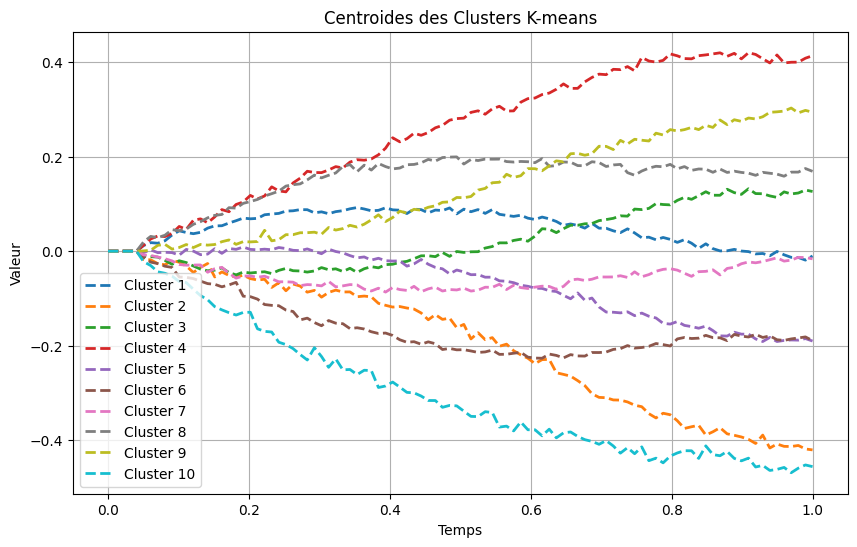

In [5]:
samples = generate_ARp_samples(1000, nb_discretization_points, interval_length, coefficients, sigma, init_values)

# Convertir en numpy pour clustering
samples_np = samples.squeeze(-1)  # [batch_size, nb_step_simulation]

# Appliquer K-means sur les trajectoires
nb_clusters = 10  # Nombre de clusters
kmeans = KMeans(n_clusters=nb_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(samples_np)

# Obtenir les centroides des clusters
kmeans_centroids = kmeans.cluster_centers_

# Tracer les centroides des clusters
time = np.linspace(0, 1, interval_length)
plt.figure(figsize=(10, 6))

for i, centroid in enumerate(kmeans_centroids):
    plt.plot(time, centroid, label=f'Cluster {i + 1}', linestyle='--', linewidth=2)

plt.title("Centroides des Clusters K-means")
plt.xlabel("Temps")
plt.ylabel("Valeur")
plt.legend()
plt.grid(True)
plt.show()


In [18]:

def train_tMCL(
    model, 
    num_epochs, 
    batch_size, 
    nb_step_simulation, 
    nb_timesteps_discretisation, 
    device, 
    learning_rate=0.001, 
    init_values=None,
    p=2,
    coefficients = [0.8,0.02],
    sigma=0.002

):
    """
    Entraîne le réseau de neurones tMCL avec des trajectoires AR(p).

    :param model: Instance du modèle tMCL
    :param num_epochs: Nombre d'époques d'entraînement
    :param batch_size: Taille du batch pour la génération de trajectoires
    :param nb_step_simulation: Longueur des trajectoires simulées
    :param nb_timesteps_discretisation: Nombre total de points de discrétisation
    :param device: Dispositif d'exécution (CPU ou GPU)
    :param learning_rate: Taux d'apprentissage
    :param init_values: Valeurs initiales fixes pour les trajectoires (ou None pour aléatoire)
    :return: Modèle entraîné
    """
    # Définir l'optimiseur et la fonction de perte
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Basculer le modèle en mode entraînement
    model.to(device)
    model.train()

    for epoch in range(num_epochs):
        # Générer un batch de trajectoires AR(p)
        trajectories = generate_ARp_samples(
            batch_size, nb_timesteps_discretisation, nb_step_simulation, coefficients=coefficients, sigma=sigma, init_values=init_values
        ).to(device)

        # Les points de conditionnement : les p dernières valeurs de chaque trajectoire
       
        distr_args = trajectories[:, :p, :].reshape(batch_size, -1)  # [batch_size, p] context as input 

        # Cibles : target_list (les trajectoires complètes après le conditionnement)
        target_list = trajectories[:, p:, :]

        # Réinitialiser les gradients
        optimizer.zero_grad()

        # Calculer les prédictions et la perte
        loss = model.log_prob(target_list, distr_args)

        # Rétropropagation
        loss.backward()

        # Mettre à jour les poids
        optimizer.step()

        # Afficher les progrès
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

    return model
p=5
batch_size = 5000
nb_step_simulation = 100 -p # 100 - p (avec p=2 ici)
nb_timesteps_discretisation = 300
init_values = None # [0,0] #[0.5, 0.2, 0.3]  # Peut être None si non fixé AR(3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Définir les hyperparamètres du modèle
model = tMCL(
    cond_dim=p,  # Nombre de valeurs pour conditionner
    nb_step_simulation=nb_step_simulation-p,
    n_hypotheses=10,
    device=device,
    loss_type="wta"
)

# Lancer l'entraînement
trained_model = train_tMCL(
    model=model,
    num_epochs=200,
    batch_size=batch_size,
    nb_step_simulation=nb_step_simulation,
    nb_timesteps_discretisation=nb_timesteps_discretisation,
    device=device,
    learning_rate=0.001,
    init_values=init_values,
    p=p,
    coefficients=  [0.4,0.2,0.2,0.1,0.1], #[0.95,0.02]
    sigma=np.sqrt(1/nb_timesteps_discretisation)
)



Epoch [10/200], Loss: 1.8097
Epoch [20/200], Loss: 1.0396
Epoch [30/200], Loss: 0.8454
Epoch [40/200], Loss: 0.7672
Epoch [50/200], Loss: 0.7270
Epoch [60/200], Loss: 0.7024
Epoch [70/200], Loss: 0.6879
Epoch [80/200], Loss: 0.6763
Epoch [90/200], Loss: 0.6766
Epoch [100/200], Loss: 0.6702
Epoch [110/200], Loss: 0.6610
Epoch [120/200], Loss: 0.6562
Epoch [130/200], Loss: 0.6519
Epoch [140/200], Loss: 0.6551
Epoch [150/200], Loss: 0.6627
Epoch [160/200], Loss: 0.6470
Epoch [170/200], Loss: 0.6416
Epoch [180/200], Loss: 0.6588
Epoch [190/200], Loss: 0.6552
Epoch [200/200], Loss: 0.6358


In [19]:
def plot_predictions(predictions, x0, nb_step_simulation):
    """
    Trace les trajectoires prédites par le modèle à partir des points initiaux x0.
    
    :param predictions: Tenseur de dimension [batch_size, K, nb_step_simulation] (prédictions du modèle)
    :param x0: Points initiaux x0, tensor [batch_size, 1]
    :param nb_step_simulation: Nombre d'étapes de simulation
    """
    batch_size, num_hypotheses, _ = predictions.shape
    
    # Configuration des axes
    time = torch.linspace(0, 1, nb_step_simulation).cpu().numpy()  # Discrétisation sur [0, 1]

    plt.figure(figsize=(12, 6))
    
    for i in range(batch_size):
        plt.subplot(1, batch_size, i + 1)
        
        # Tracer toutes les hypothèses pour un exemple
        for k in range(num_hypotheses):
            plt.plot(time, predictions[i, k].detach().cpu().numpy(), label=f'Hypothesis {k + 1}')
        
        plt.title(f'Trajectories for x0={x0[i].item():.2f}')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

initial_points = torch.tensor([[0.15,0.15]])  # Points initiaux x0

# Faire passer les points initiaux dans le modèle
predictions = trained_model.forward(initial_points)  # Sortie: [1, 10, 96]

# Ajuster initial_points pour être compatible avec la forme des prédictions
initial_points = initial_points.unsqueeze(1).expand(-1, predictions.shape[1], -1)  # [1, 10, 2]

# Concaténer les points initiaux avec les prédictions
full_trajectory = torch.cat((initial_points, predictions), dim=2)  # [1, 10, 98]

plot_predictions(full_trajectory, torch.tensor([[ -1.4]]), nb_step_simulation)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x2 and 5x200)

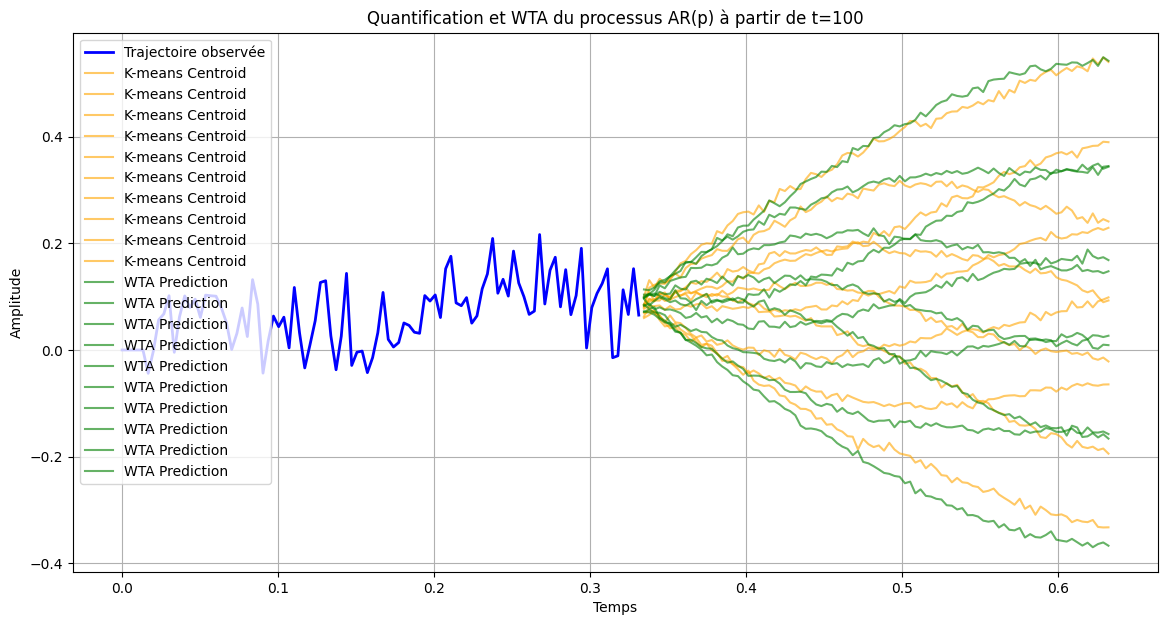

In [29]:
batch_size = 110
nb_discretization_points = 300
interval_length = 100
coefficients = [0.4,0.2,0.2,0.1,0.1] # AR(3) exemple
sigma = np.sqrt(1/nb_discretization_points)

init_values = [0.0,0.0,0.0,0.0,0.0] #None#[0.5, 0.2, 0.3]  # Peut être une liste de longueur p si nécessaire
p =len(coefficients)
# Choix du point de conditionnement
t_condition = 100  # Point de coupure pour la quantification


# Générer une trajectoire complète d'un processus AR(p)
nb_steps = nb_discretization_points
y = np.zeros(nb_steps)

# Initialisation
p = len(coefficients)
y[:p] = init_values

# Génération du processus AR(p)
for t in range(p, nb_steps):
    noise = np.random.randn() * sigma
    y[t] = sum(coefficients[i] * y[t - (i + 1)] for i in range(p)) + noise


y_observed = y[:t_condition]  # Partie observée
y_future = y[t_condition:]  # Partie à estimer

init_values = y_observed[-p:] #last observed points of y
# Appliquer K-means sur les parties futures des trajectoires
nb_clusters = 10  # Nombre de clusters

samples = generate_ARp_samples(1000, nb_discretization_points, interval_length+p, coefficients, sigma, list(init_values))
samples_np = samples.squeeze(-1)

# Quantification conditionnelle avec K-means
kmeans = KMeans(n_clusters=nb_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(samples_np)
kmeans_centroids = kmeans.cluster_centers_


# Prédictions du modèle tMCL (assurez-vous que trained_model est bien chargé)
init_values = list(init_values)  # Exemple de liste
init_values = [float(x) for x in init_values]  # Convertir chaque élément en float

x_condition = torch.tensor([init_values])  # Conditionnement sur la dernière valeur observée
predictions_neural = trained_model.forward(x_condition)[0].detach().numpy()  # Prédictions WTA

# Tracer les trajectoires conditionnées et leurs quantifications
time_full = np.linspace(0, 1, nb_steps)
time_observed = time_full[:t_condition]
time_future = time_full[t_condition:t_condition + predictions_neural.shape[1]]

plt.figure(figsize=(14, 7))

# Tracer la partie observée
plt.plot(time_observed, y_observed, label="Trajectoire observée", color='blue', linewidth=2)

# Tracer les centroides de K-means (quantification conditionnelle)
for centroid in kmeans_centroids:
    plt.plot(time_future, centroid[p:len(time_future)+p], alpha=0.6, color='orange', label="K-means Centroid")

# Tracer les prédictions du modèle tMCL
for trajectory in predictions_neural:
    plt.plot(time_future, trajectory, alpha=0.6, color='green', label="WTA Prediction")

plt.title(f"Quantification et WTA du processus AR(p) à partir de t={t_condition}")
plt.xlabel("Temps")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()
